In [260]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt 

%matplotlib inline
from scipy import stats
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller, zivot_andrews

# Introducción

Cuando se realizan pruebas de raíz unitaria, se debe tener cuidado si se sospecha que ha ocurrido un cambio estructural. Cuando hay rupturas estructurales, los estadísticos de la prueba Dickey-Fuller están sesgadas hacia el no rechazo de una raíz unitaria. 

In [470]:
n =240

y = np.zeros(n) 
z = np.zeros(n)
trend = np.zeros(n) 

for i in range(0,n):
    
    e = np.random.normal(0, 1, 1)
    
    trend[i]=i
    
    if i>=120:
        y[i] = 0.50*y[i-1] + 10 + e
        
    else:
        y[i]=0.5*y[i-1]+e
        
        
    if i==120:
        z[i] = z[i-1] + 10 + e
    else:
        z[i]=z[i-1]+e

y = pd.Series(y)    
z = pd.Series(z)  

frame = {'y':y,'z':z,'t':trend}

In [471]:
df = pd.DataFrame(frame) 
df.index = pd.period_range('1981-01-01', '2000-12-01', freq='M')

# df['d'] = (df.index >= '1990-01-01').astype(int)

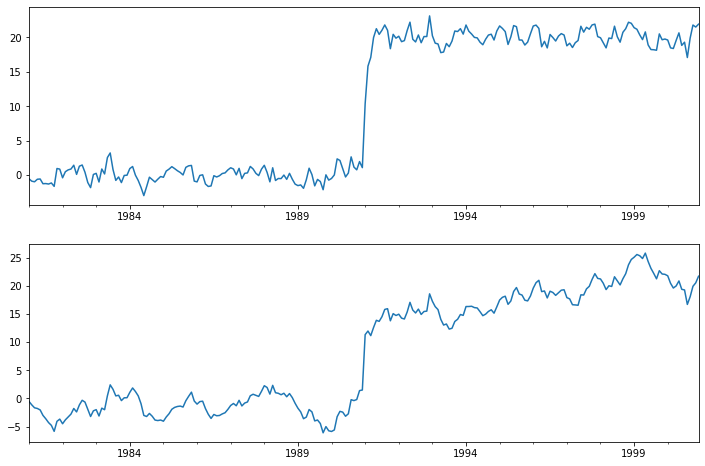

In [472]:
figure, axes = plt.subplots(2, 1)
df['y'].plot(ax=axes[0],figsize=(12,8))
df['z'].plot(ax=axes[1],figsize=(12,8))


In [473]:
df

,y,z,t
1981-01,-0.518037,-0.518037,0.0
1981-02,-0.876506,-1.135525,1.0
1981-03,-0.964463,-1.661734,2.0
1981-04,-0.597993,-1.777496,3.0
1981-05,-0.560271,-2.038770,4.0
...,...,...,...
2000-08,17.086900,16.692370,235.0
2000-09,19.905141,18.054061,236.0
2000-10,21.809013,19.910504,237.0
2000-11,21.516129,20.522126,238.0


In [474]:
def adf_test(timeseries,exog):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=5,regression=exog,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Test DF: Z and Y 

In [475]:
adf_test(df['y'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -2.037183
p-value                          0.581042
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.997157
Critical Value (5%)             -3.429021
Critical Value (10%)            -3.137939
dtype: float64


In [476]:
adf_test(df['z'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -2.359417
p-value                          0.401405
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.997157
Critical Value (5%)             -3.429021
Critical Value (10%)            -3.137939
dtype: float64


## Estimacion de la regresion

$\Delta y_t  = a_0 + \gamma y_{t − 1} + a_2t + e_t$

In [477]:
df['ly']=df['y'].shift()
df['dy']=df['y'].diff()
df['dly1']=df['dy'].shift()
df['dly2']=df['dy'].shift(periods=2)
# df['dly3']=df['dy'].shift(periods=3)
df['lz']=df['z'].shift()
df['dz']=df['z'].diff()
df['dlz1']=df['dz'].shift()
df['dlz2']=df['dz'].shift(periods=2)
df=df[3:]

In [478]:
df.head()

,y,z,t,ly,dy,dly1,dly2,lz,dz,dlz1,dlz2
1981-04,-0.597993,-1.777496,3.0,-0.964463,0.366470,-0.087957,-0.358469,-1.661734,-0.115761,-0.526210,-0.617487
1981-05,-0.560271,-2.038770,4.0,-0.597993,0.037722,0.366470,-0.087957,-1.777496,-0.261274,-0.115761,-0.526210
1981-06,-1.246175,-3.004809,5.0,-0.560271,-0.685904,0.037722,0.366470,-2.038770,-0.966039,-0.261274,-0.115761
1981-07,-1.224299,-3.606021,6.0,-1.246175,0.021876,-0.685904,0.037722,-3.004809,-0.601211,-0.966039,-0.261274
1981-08,-1.293018,-4.286889,7.0,-1.224299,-0.068719,0.021876,-0.685904,-3.606021,-0.680869,-0.601211,-0.966039


In [479]:
X1 = [df['t'],df['ly']]
X1 = np.column_stack(X1)
X1 = sm.add_constant(X1)

model1 = sm.OLS(df['dy'],X1)
results1 = model1.fit()

print(results1.summary(xname=['const','trend','ly']))

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.018
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.135
Time:                        15:55:43   Log-Likelihood:                -396.13
No. Observations:                 237   AIC:                             798.3
Df Residuals:                     234   BIC:                             808.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0919      0.193     -0.477      0.6

In [480]:
X2 = [df['t'],df['lz']]
X2 = np.column_stack(X2)
X2 = sm.add_constant(X2)

model2 = sm.OLS(df['dz'],X2)
results2 = model2.fit()

print(results2.summary(xname=['const','trend','lz']))

                            OLS Regression Results                            
Dep. Variable:                     dz   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.618
Date:                Thu, 09 Jul 2020   Prob (F-statistic):             0.0751
Time:                        15:55:44   Log-Likelihood:                -365.80
No. Observations:                 237   AIC:                             737.6
Df Residuals:                     234   BIC:                             748.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2617      0.205     -1.276      0.2

## Evaluamos la hipotesis

$\gamma = a_2 =0$

In [481]:
print(results1.f_test('x1=x2=0'))


<F test: F=array([[2.018473]]), p=0.13516494362725476, df_denom=234, df_num=2>


In [482]:
print(results2.f_test('x1=x2=0'))

<F test: F=array([[2.61770948]]), p=0.07510596486828754, df_denom=234, df_num=2>


<img src="fig9.png" align="center"  width="500" height="350">

# Prueba de Zivot y Anadrews

La prueba de Zivot-Andrews analizar si la serie tiene un (y solo un) quiebre estructural. En la prueba de Zivot-Andrews la hipótesis nula es que la serie tiene una raíz unitaria con quibre estructural contra la hipótesis alternativa de que son estacionarias con quiebre. Rechazar Nulo si la estadística de valor t es inferior al valor crítico tabulado.

In [483]:
def zivot(timeseries,exog):
    print ('Results of Zivot-Andrews Test:')
    dftest = zivot_andrews(timeseries, trim=0.10, maxlag=None,regression=exog,autolag=None)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[2].items():
        dfoutput['Critical Value (%s)'%key] = value
    #dfoutput['Number of lags']=pd.Series(dftest[3:4])
    dfoutput['break']=pd.Series(dftest[4])
    print (dfoutput)

In [484]:
zivot(df['y'],'c')

Results of Zivot-Andrews Test:
Test Statistic                       -13.2791
p-value                                 1e-05
Critical Value (1%)                  -5.27644
Critical Value (5%)                  -4.81067
Critical Value (10%)                 -4.56618
break                   0    116
dtype: int64
dtype: object


In [485]:
zivot(df['y'],'t')

Results of Zivot-Andrews Test:
Test Statistic                       -2.52036
p-value                              0.890836
Critical Value (1%)                  -5.03421
Critical Value (5%)                   -4.4058
Critical Value (10%)                 -4.13678
break                   0    162
dtype: int64
dtype: object


In [486]:
zivot(df['y'],'ct')

Results of Zivot-Andrews Test:
Test Statistic                       -13.0182
p-value                           0.000794587
Critical Value (1%)                  -5.57556
Critical Value (5%)                  -5.07332
Critical Value (10%)                 -4.82668
break                   0    116
dtype: int64
dtype: object


# Correcion de la serie

In [487]:
df['d'] = (df.index >= '1989-09-01').astype(int)

C:\Users\lfsanche\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [496]:
X3 = [df['d']]
X3 = np.column_stack(X3)
X3 = sm.add_constant(X3)

model3 = sm.OLS(df['y'],X3)
results3 = model3.fit()

print(results3.summary(xname=['const','d']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     747.4
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           6.05e-75
Time:                        15:59:05   Log-Likelihood:                 564.21
No. Observations:                 237   AIC:                            -1124.
Df Residuals:                     235   BIC:                            -1117.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.094      0.9

In [527]:
df['y_new'] = df['y']-df['d']*0.0807

df['res']=results3.resid


C:\Users\lfsanche\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\lfsanche\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [528]:
df

,y,z,t,ly,dy,dly1,dly2,lz,dz,dlz1,dlz2,d,y_new,red,res
1981-04,-0.002718,-1.777496,3.0,-0.964463,0.366470,-0.087957,-0.358469,-1.661734,-0.115761,-0.526210,-0.617487,0,-0.002718,-0.002508,-0.002508
1981-05,-0.002547,-2.038770,4.0,-0.597993,0.037722,0.366470,-0.087957,-1.777496,-0.261274,-0.115761,-0.526210,0,-0.002547,-0.002336,-0.002336
1981-06,-0.005664,-3.004809,5.0,-0.560271,-0.685904,0.037722,0.366470,-2.038770,-0.966039,-0.261274,-0.115761,0,-0.005664,-0.005454,-0.005454
1981-07,-0.005565,-3.606021,6.0,-1.246175,0.021876,-0.685904,0.037722,-3.004809,-0.601211,-0.966039,-0.261274,0,-0.005565,-0.005355,-0.005355
1981-08,-0.005877,-4.286889,7.0,-1.224299,-0.068719,0.021876,-0.685904,-3.606021,-0.680869,-0.601211,-0.966039,0,-0.005877,-0.005667,-0.005667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-08,0.077669,16.692370,235.0,19.311044,-2.224144,0.457715,-1.818108,19.260992,-2.568622,-0.115620,-1.482390,1,-0.003031,-0.002830,-0.002830
2000-09,0.090479,18.054061,236.0,17.086900,2.818241,-2.224144,0.457715,16.692370,1.361691,-2.568622,-0.115620,1,0.009779,0.009980,0.009980
2000-10,0.099133,19.910504,237.0,19.905141,1.903872,2.818241,-2.224144,18.054061,1.856442,1.361691,-2.568622,1,0.018433,0.018634,0.018634
2000-11,0.097802,20.522126,238.0,21.809013,-0.292883,1.903872,2.818241,19.910504,0.611623,1.856442,1.361691,1,0.017102,0.017303,0.017303


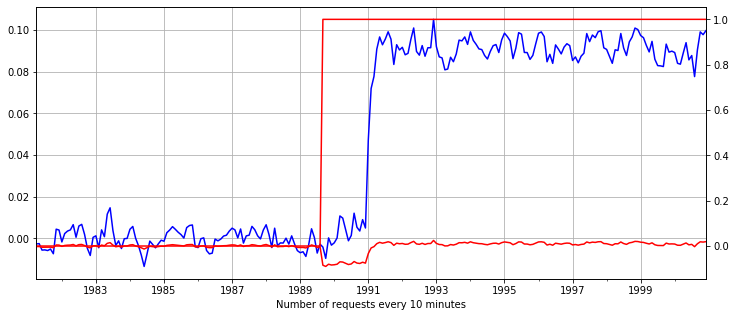

In [532]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df.y.plot(color='blue', grid=True, label='original')
ax2 = df.d.plot(color='red', grid=True, secondary_y=True, label='fixed')
ax3 = df.res.plot(color='red', grid=True, secondary_y=True, label='fixed')

plt.show()

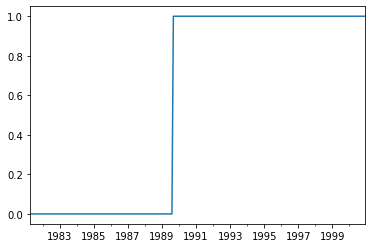

In [526]:
df['d'].plot()